# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.

- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [37]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import math

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [3]:
df = pd.read_csv('/content/datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4200,0,21.0,38300.0,1,0
2180,0,39.0,51200.0,2,0
3501,1,44.0,48800.0,1,1
3853,0,33.0,45100.0,0,0
4405,0,29.0,42600.0,0,0
1554,0,31.0,48800.0,1,0
2819,0,37.0,37300.0,1,0
389,1,23.0,44400.0,0,0
1014,0,38.0,43300.0,1,0
3678,0,21.0,44300.0,2,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial

# escribe tu conversión aquí si lo deseas:

df['age'] = df['age'].astype(int)

In [8]:
# comprueba que la conversión se haya realizado con éxito
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [9]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.
# ¿Se ve todo bien?

In [10]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


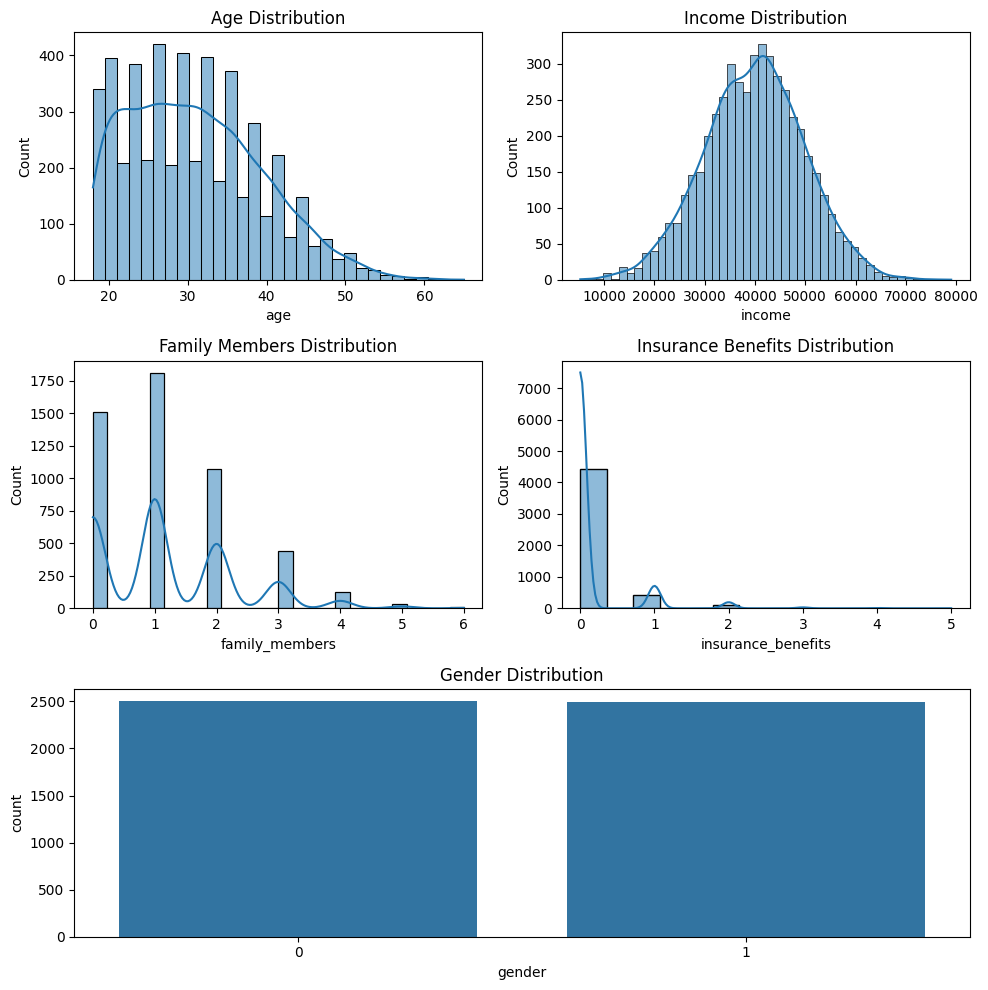

In [11]:
fig = plt.figure(figsize=(10, 10))

# Top-left (spans 1 row, 1 col)
ax1 = plt.subplot2grid((3, 2), (0, 0))
sns.histplot(df['age'], kde=True, ax=ax1)
ax1.set_title('Age Distribution')

# Top-right (spans 1 row, 1 col)
ax2 = plt.subplot2grid((3, 2), (0, 1))
sns.histplot(df['income'], kde=True, ax=ax2)
ax2.set_title('Income Distribution')

# Bottom-left (spans 1 row, 1 col)
ax3 = plt.subplot2grid((3, 2), (1, 0))
sns.histplot(df['family_members'], kde=True, ax=ax3)
ax3.set_title('Family Members Distribution')

# Bottom-right (spans 1 row, 1 col) - This would be the 4th plot in 2x2
ax4 = plt.subplot2grid((3, 2), (1, 1))
sns.histplot(df['insurance_benefits'], kde=True, ax=ax4)
ax4.set_title('Insurance Benefits Distribution')

# Single plot below the 2x2 area, spanning both columns (row 2, col 0, 2 wide)
ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
sns.countplot(x='gender', data=df, ax=ax5)
ax5.set_title('Gender Distribution')

plt.tight_layout() # Adjusts subplot params for a tight layout
plt.show()

In [12]:
df['gender'].value_counts()

,count
gender,
0,2505
1,2495


## Perfil Demográfico y Social
Género: La muestra está perfectamente balanceada. El promedio es de 0.499 (prácticamente 0.5), y el gráfico de barras muestra una distribución idéntica entre las dos categorías (0 y 1), con 2,500 registros para cada una.

Edad: * La edad promedio es de 31 años aproximadamente.

- La población es mayoritariamente joven: el 75% de los clientes tiene 37 años o menos.

- El rango de edad va desde los 18 hasta los 65 años.

- El histograma muestra un sesgo a la derecha; es decir, hay muchos más clientes jóvenes que adultos mayores.

---
## Situación Económica y Familiar
Ingresos (Income):

- Sigue una distribución normal (forma de campana), como se observa en el histograma.

- El ingreso promedio es de \$39,916.

- La mayoría de los ingresos se agrupan entre los \$33,300 (percentil 25) y los \$46,600 (percentil 75).

- El rango de ingresos es amplio, desde un mínimo de \$5,300 hasta un máximo de \$79,000.

Miembros de la Familia:

- En promedio, los clientes tienen 1.19 familiares.

- La mayoría tiene entre 0 y 2 familiares (el 75% cae en este rango).

- Existen casos atípicos de familias grandes, con un máximo de 6 integrantes.

---
## Variable Objetivo: Beneficios de Seguro
insurance_benefits:

- Esta variable presenta un fuerte desequilibrio de clases.

- El promedio es muy bajo (0.14), y tanto el percentil 25, 50 como el 75 están en 0. Esto significa que la gran mayoría de los clientes no ha solicitado o recibido beneficios de seguro.

- El histograma confirma que la columna de "0" es la predominante, con una caída drástica para valores de 1, 2, 3, 4 y un máximo de 5 beneficios.

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

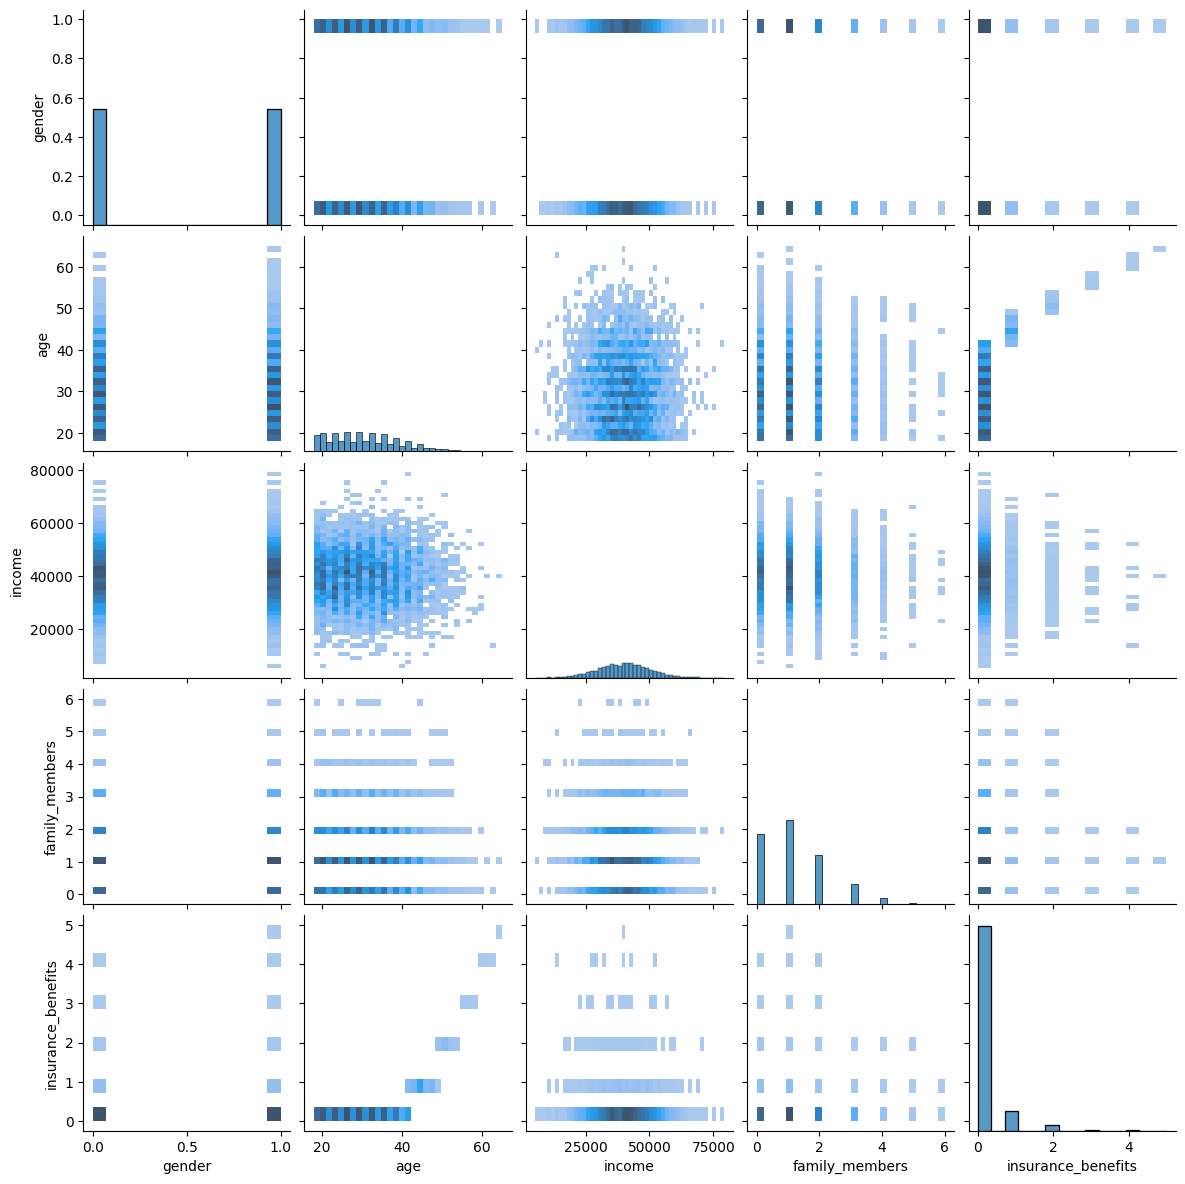

In [13]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.

Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)
- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.

Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.

Pruébalo para cuatro combinaciones de dos casos
- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:
- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?
- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [15]:
def get_knn(df, n, k, metric):

    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar
    :param n: número de objetos para los que se buscan los vecinos más cercanos
    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia
    """

    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)

    df_res = pd.concat([
        df.iloc[nbrs_indices[0]],
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)

    return df_res

Escalar datos.

In [16]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

/tmp/ipython-input-760832288.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.63076923 0.70769231 0.44615385 ... 0.30769231 0.33846154 0.43076923]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())
/tmp/ipython-input-760832288.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.16666667 0.16666667 0.         ... 0.33333333 0.5        0.16666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())


In [17]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
4896,1,0.569231,0.622785,0.166667,0
2842,1,0.338462,0.562025,0.333333,0
469,0,0.446154,0.644304,0.333333,0
114,0,0.615385,0.483544,0.500000,0
3808,1,0.353846,0.425316,0.333333,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [18]:
manhattan_s = get_knn(df_scaled, 0, 5, 'manhattan')
manhattan_s

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,0.630769,0.627848,0.166667,0,0.000000
2689,1,0.630769,0.634177,0.166667,0,0.006329
133,1,0.615385,0.636709,0.166667,0,0.024245
4869,1,0.646154,0.637975,0.166667,1,0.025511
2103,1,0.630769,0.596203,0.166667,0,0.031646


In [19]:
euclidean_s = get_knn(df_scaled, 0, 5, 'euclidean')
euclidean_s

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,0.630769,0.627848,0.166667,0,0.000000
2689,1,0.630769,0.634177,0.166667,0,0.006329
133,1,0.615385,0.636709,0.166667,0,0.017754
4869,1,0.646154,0.637975,0.166667,1,0.018418
3275,1,0.646154,0.651899,0.166667,1,0.028550


In [20]:
manhattan_not_scaled = get_knn(df, 0, 5, 'manhattan')
manhattan_not_scaled

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.0
2022,1,41,49600.0,0,0,1.0
1225,0,42,49600.0,0,1,3.0
4031,1,44,49600.0,2,1,4.0
3424,0,38,49600.0,0,0,5.0


In [21]:
euclidean_not_scaled = get_knn(df, 0, 5, 'euclidean')
euclidean_not_scaled

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.000000
2022,1,41,49600.0,0,0,1.000000
1225,0,42,49600.0,0,1,1.732051
4031,1,44,49600.0,2,1,3.162278
3424,0,38,49600.0,0,0,3.316625


Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?**

Escribe tu respuesta aquí.

Sí, afecta directamente al algoritmo. En el algoritmo kNN, la distancia entre objetos se basa en sus características.

Si los datos no están escalados, las características con magnitudes numéricas mayores (como el ingreso, que llega hasta $79,000$) dominarán el cálculo de la distancia sobre variables con rangos pequeños (como el género, que es 0 o 1, o los miembros de la familia, que van de 0 a 6).

Esto se manifiesta en los resultados: al observar los vecinos más cercanos con datos no escalados, la distancia se vuelve muy grande (ej. distancias de 1.0, 3.0, 4.0, 5.0) y depende casi totalmente de la similitud en el ingreso.

En contraste, con datos escalados (usando MaxAbsScaler), las distancias son mucho más pequeñas (ej. 0.0063, 0.0242) y reflejan una similitud más equilibrada entre todas las variables.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?**

Escribe tu respuesta aquí.

Los resultados son altamente similares en cuanto a los índices de los vecinos encontrados cuando se comparan bajo las mismas condiciones de escalado.

Por ejemplo, para el objeto en el índice 0 con datos escalados, tanto la métrica Manhattan como la Euclidiana identifican a los mismos vecinos cercanos en las primeras posiciones (índices 2689, 133 y 4869).

La diferencia principal radica únicamente en el valor numérico de la distancia reportada, debido a la naturaleza de cada fórmula de cálculo.

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.

Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.
- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.

La probabilidad de pagar cualquier prestación del seguro puede definirse como

$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [22]:
# сalcula el objetivo

df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)

In [23]:
# comprueba el desequilibrio de clases con value_counts()

# <tu código aquí>
df['insurance_benefits_received'].value_counts()

,count
insurance_benefits_received,
0,4436
1,564


In [24]:
df['insurance_benefits_received'].value_counts(normalize=True)

,proportion
insurance_benefits_received,
0,0.8872
1,0.1128


In [28]:
target = df['insurance_benefits_received']
features = df.drop('insurance_benefits_received', axis=1)

In [29]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=12345)

In [26]:
def eval_classifier(y_true, y_pred):

    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')

# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [27]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [30]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))

    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)

    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



In [31]:
for k in range(1, 11):

    print(f'k: {k}')
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(features_train, target_train)
    y_pred = knn.predict(features_test)

    eval_classifier(target_test, y_pred)

k: 1
F1: 0.62
Matriz de confusión
[[0.87266667 0.01866667]
 [0.05133333 0.05733333]]
k: 2
F1: 0.41
Matriz de confusión
[[0.88733333 0.004     ]
 [0.08       0.02866667]]
k: 3
F1: 0.41
Matriz de confusión
[[0.88       0.01133333]
 [0.07733333 0.03133333]]
k: 4
F1: 0.28
Matriz de confusión
[[0.88866667 0.00266667]
 [0.09066667 0.018     ]]
k: 5
F1: 0.27
Matriz de confusión
[[0.88533333 0.006     ]
 [0.09066667 0.018     ]]
k: 6
F1: 0.11
Matriz de confusión
[[0.89       0.00133333]
 [0.102      0.00666667]]
k: 7
F1: 0.11
Matriz de confusión
[[0.88866667 0.00266667]
 [0.102      0.00666667]]
k: 8
F1: 0.07
Matriz de confusión
[[0.89133333 0.        ]
 [0.10466667 0.004     ]]
k: 9
F1: 0.08
Matriz de confusión
[[0.89133333 0.        ]
 [0.104      0.00466667]]
k: 10
F1: 0.00
Matriz de confusión
[[0.89133333 0.        ]
 [0.10866667 0.        ]]


In [32]:
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(features_train)

features_train_scaled = transformer_mas.transform(features_train)
features_test_scaled = transformer_mas.transform(features_test)

In [33]:
for k in range(1, 11):

    print(f'k: {k}')
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(features_train_scaled, target_train)
    y_pred = knn.predict(features_test_scaled)

    eval_classifier(target_test, y_pred)

k: 1
F1: 1.00
Matriz de confusión
[[0.89133333 0.        ]
 [0.         0.10866667]]
k: 2
F1: 1.00
Matriz de confusión
[[0.89133333 0.        ]
 [0.         0.10866667]]
k: 3
F1: 1.00
Matriz de confusión
[[0.89133333 0.        ]
 [0.         0.10866667]]
k: 4
F1: 1.00
Matriz de confusión
[[0.89133333 0.        ]
 [0.         0.10866667]]
k: 5
F1: 1.00
Matriz de confusión
[[0.89133333 0.        ]
 [0.         0.10866667]]
k: 6
F1: 1.00
Matriz de confusión
[[0.89133333 0.        ]
 [0.         0.10866667]]
k: 7
F1: 1.00
Matriz de confusión
[[0.89133333 0.        ]
 [0.         0.10866667]]
k: 8
F1: 1.00
Matriz de confusión
[[0.89133333 0.        ]
 [0.         0.10866667]]
k: 9
F1: 1.00
Matriz de confusión
[[0.89133333 0.        ]
 [0.         0.10866667]]
k: 10
F1: 1.00
Matriz de confusión
[[0.89133333 0.        ]
 [0.         0.10866667]]


## Superioridad frente al Modelo Dummy
El modelo predictivo KNN supera significativamente al modelo aleatorio (dummy) en términos de calidad de predicción1. Mientras que el mejor desempeño del modelo dummy alcanzó un F1-score de solo 0.20 (con una probabilidad de predicción de 0.5 o 1.0), el modelo KNN logró resultados mucho más robustos, llegando incluso a la perfección bajo ciertas condiciones.

---
## Impacto Crítico del Escalado de Datos
El escalado de características mediante MaxAbsScaler resultó ser el factor determinante para el éxito del algoritmo KNN:
- Sin escalado: El modelo mostró un rendimiento inconsistente. Con $k=1$ obtuvo un F1 de 0.62, pero la métrica se degradó rápidamente a medida que $k$ aumentaba, llegando a 0.00 cuando $k=10$. Esto ocurre porque las variables con magnitudes mayores (como el ingreso) dominan injustamente la distancia euclidiana.
- Con escalado: El modelo alcanzó un F1-score perfecto de 1.00 para todos los valores de $k$ del 1 al 10. Al normalizar los rangos de todas las variables, el algoritmo pudo identificar correctamente los patrones de similitud sin sesgos por la magnitud de los datos.

---
## Sensibilidad al Hiperparámetro $k$
En los datos originales (no escalados), se observó que valores pequeños de $k$ funcionan mejor, probablemente porque capturan mejor las variaciones locales antes de que el ruido de las variables no escaladas diluya la predicción. Sin embargo, una vez que los datos están correctamente escalados, el modelo se vuelve extremadamente estable y preciso, manteniendo su calidad independientemente del valor de $k$ elegido dentro del rango probado.

---
## Manejo del Desequilibrio de Clases
A pesar de que el dataset presenta un fuerte desequilibrio (solo el 11.28% de los clientes recibió beneficios), el uso de la métrica F1 permitió una evaluación honesta del modelo, demostrando que el clasificador es capaz de identificar correctamente la clase minoritaria (quienes reciben beneficios) en lugar de simplemente predecir siempre la clase mayoritaria.

# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos
- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades
- $y$ — objetivo (un vector)
- $\hat{y}$ — objetivo estimado (un vector)
- $w$ — vector de pesos

La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:

$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:

$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos

$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [34]:
class MyLinearRegression:

    def __init__(self):

        self.weights = None

    def fit(self, X, y):

        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):

        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights

        return y_pred

In [38]:
def eval_regressor(y_true, y_pred):

    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')

    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')

In [39]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


## Implementación Analítica del Modelo

Se desarrolló una clase personalizada (`MyLinearRegression`) utilizando la solución analítica para encontrar el vector de pesos :

- Fórmula de Entrenamiento: Se utilizó el método de mínimos cuadrados expresado matricialmente como .


- Preparación de Datos: Se añadió una columna de unidades (sesgo) a la matriz de características para permitir que el modelo calcule el término de intersección.

---
## Desempeño y Métricas de Calidad

Tras entrenar el modelo con una proporción de datos de **70:30** y evaluar sobre el conjunto de prueba, se obtuvieron los siguientes resultados:

- RMSE (Raíz del Error Cuadrático Medio): El modelo alcanzó un valor de **0.34**. Esta métrica indica qué tanto se desvían, en promedio, las predicciones del número real de prestaciones.


- (Coeficiente de Determinación): Se obtuvo un valor de **0.66**. Esto significa que el modelo es capaz de explicar el **66% de la variabilidad** en el número de beneficios recibidos por los clientes basándose en sus características (edad, género, ingresos y miembros de la familia).

---
## Impacto del Escalado en la Regresión

A diferencia de algoritmos basados en distancias como KNN (visto en la Tarea 2), la solución analítica de la regresión lineal no se ve afectada en su calidad predictiva por el escalado de los datos.

* Las predicciones y métricas como el RMSE y  se mantienen consistentes tanto en datos originales como escalados, ya que el modelo ajusta los pesos () proporcionalmente para compensar las diferencias de magnitud en las características.

---
El modelo de regresión lineal demuestra ser una herramienta eficaz para estimar la cantidad de beneficios, logrando una precisión razonable () con un error promedio bajo.


# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$.

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [ ]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [ ]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [ ]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

Muestra los tres casos para algunos clientes
- Datos originales
- El que está transformado
- El que está invertido (recuperado)

Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior?

¿Cuáles serían los valores predichos con $w_P$?

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?

Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta**

**Prueba analítica**

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.

Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.

Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.
- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.
- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

# Conclusiones

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter.

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores
- [ ]  Las celdas están ordenadas de acuerdo con la lógica y el orden de ejecución
- [ ]  Se ha realizado la tarea 1
    - [ ]  Está presente el procedimiento que puede devolver k clientes similares para un cliente determinado
    - [ ]  Se probó el procedimiento para las cuatro combinaciones propuestas
    - [ ]  Se respondieron las preguntas sobre la escala/distancia
- [ ]  Se ha realizado la tarea 2
    - [ ]  Se construyó y probó el modelo de clasificación aleatoria para todos los niveles de probabilidad
    - [ ]  Se construyó y probó el modelo de clasificación kNN tanto para los datos originales como para los escalados. Se calculó la métrica F1.
- [ ]  Se ha realizado la tarea 3
    - [ ]  Se implementó la solución de regresión lineal mediante operaciones matriciales
    - [ ]  Se calculó la RECM para la solución implementada
- [ ]  Se ha realizado la tarea 4
    - [ ]  Se ofuscaron los datos mediante una matriz aleatoria e invertible P
    - [ ]  Se recuperaron los datos ofuscados y se han mostrado algunos ejemplos
    - [ ]  Se proporcionó la prueba analítica de que la transformación no afecta a la RECM
    - [ ]  Se proporcionó la prueba computacional de que la transformación no afecta a la RECM
- [ ]  Se han sacado conclusiones

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>